## Time-lapse imaging and dynamic surfaces

Development and many other biological processes are highly dynamic, and often we use time-lapse imaging to watch these processes live. How can we analyze three-dimensional movies using tissue cartography? We somehow want a "consistent" cartographic projection across all timepoints of our movie.

Below, we explain the nuts and bolts of our approach in some detail. If you want a notebook to use as a template for your data, look at tutorial XXX.


## TO DO -  add some figures

#### 1. Dynamic data, fixed surface
In the simplest case, even though there is some interesting dynamics in the fluorescence microscopy data, our surface of interest does not change over time. For example, there are many instances during development where cells are moving across an essentially fixed surface, for example during Zebrafish epiboly or germband extension in _Drosophila_. In this case, we are in luck: we can simly re-use the same mesh and UV map we created for the first timepoint to make cartographic projection for the subsequent frames.

#### 2. Surface undergoing rigid motion
A slightly more general case can also be handled easily: the surface of interest does not deform, and only moves, rotates, or changes in scale. In this case we just need to translate/rotate/scale our original mesh and we are done. The tools for this are provided in the `registration` module.

#### 3. Surface undergoing non-rigid deformation
If the surface of interest is dynamically changing its shape, the problem becomes, in general, _considerably_ more difficult. Indeed, it is in general not a well-defined mathematical quesion what a "consistent" cartographic projection for potentially very different looking surfaces would be.

There are two possible strategies for getting a consistent cartographic projection for all time points:

1. Compute the cartographic projection at each timepoint individually, but using a consistent algorithmic procedure. For example, for a surface that ressembles a deforming tube, you could always compute a cylindrical projection along the object's long axis at each time. This approach is the basis of the [Tubular](https://www.nature.com/articles/s41592-023-02081-w) software by Mitchell and Cislo. However, we will not pursue it here: what cartographic projection algorithm you should use strongly depends on context, and using a fixed algorithm means that you cannot define your UV maps in a graphic and interactive way. 

2. Define a UV map for a selected timepoint, your [_keyframe_](https://en.wikipedia.org/wiki/Key_frame), and map/deform your keyframe mesh to match the meshes of the other timepoints. Then you'll have a mesh with a UV map, and matching your surface of interest, allowing you to carry out cartographic projections. This is the approch we will pursue here, using the `wrapping` and `conformal` modules.

#### Small non-rigid deformation

If the deformations are not too dratic, we can use an extremely simple method:
1. Align the keyframe mesh to the mesh of the target timepoint using rigid transformations as best as as possible.
2. Project each vertex on the keyframe mesh onto the closest point on the target timepoint mesh. We will call this "shrink-wrapping", and it is implement in the `wrapping` module.
3. Smooth the shrink-wrapped mesh to smooth out creases created by shrink-wrapping.

This process can be done _iteratively_: first shrinkwrap the keyframe mesh to the mesh of the subsequent frame, then use that result and shrinkwrap it to the next-to-subsequent frame, etc.

As we will see below, it is in general a good idea to use your most "complicated" shape as keyframe. In developmental biology, where shapes generally start out simple and become more complicated over time, this means using the last timepoint as keyframe, and propagating it backwards in time.


As you iterative the shrink-wrapping, you may run into trouble if your keyframe becomes too deformed. We provide some tools for fixing this via remeshing (`remesh` and `remesh_pymeshlab` modules), but you may have to define _multiple keyframes_. 

#### Large non-rigid deformation

If there is a lot of deformation between your timepoints, shrink-wrapping will not work. We need a more powerful algorithm for computing a map from our keyframe mesh to the target mesh. There is a large literature on this question from the computer graphics literature, and we will provide some pointers below. Here, we implement a simple-to-use algorithm that does not require landmarks or any other user input. It is based on mapping each mesh to a reference shape - a disk or a sphere, depending on the topology. In the reference shape, one only has to optimize over (2d and 3d, respectively) rotations to match the two shapes. This approach, called [Moebius registration](https://www.cs.cmu.edu/~kmcrane/Projects/MobiusRegistration/paper.pdf), can handle extremely large deformations. 

Another approach for mesh-to-mesh mapping is provided by so-called "functional maps", implemented in python by [pyFM](https://github.com/RobinMagnet/pyFM). While it is not as robust, it is more general and can handle meshes of arbitrary topology. We demonstrate how to use it below.

#### Meshing and segmenation for a movie

As a starting point for any of the approaches in section 3, you will need a mesh of your surface at each movie timepoint. The process of segmenting your data for mesh creation is often the most time consuming part of the tissue cartography pipeline, and for movies it can often be accelerated by reusing information from the previous frame:
1. Train a single ilastik model to work for all (or at least multiple timepoints). You can use ilastik's "batch predict" tab for this. In this case, it is important to _standardize_ the ilastik input data (i.e. ensure consistent brightness and contrast). See `io.normalize_quantiles_zstack`
2. If you use the `morphsnakes` module to convert your ilastik probabilities into a segmentation, you can use the previous timepoint's segmentation as a seed point for the next one, which greatly improves results.

#### A note on remeshing

With meshes, we represent a surface as a collection of points (vertices) and faces connecting them. The combinatorial configuration of faces and vertices is called the mesh _topology_ (not to be confused with the topology of the surface, e.g. sphere, torus, etc.). The same surface can be represented by different meshes, for example triangular vs quad meshes. _Remeshing_ is the process of modifying a mesh so that it has a "nicer" topology without changing the shape of the surface - e.g. to ensure faces are of uniform size and not extremely deformed, or to get the right "resolutioon" (number of vertices) to represent the surface shape.

For single recordings, the mesh topology does not matter too much. But once we start deforming our meshes, it becomes very important.
1. Most remeshing will destroy UV mapping information. Therefore, try to do all your remeshing before you create UV maps.
2. Especially for your keyframe meshes, ensure you have "good" topology (uniform triangle size, no deformed triangles). For this, you can use pymeshlab (`remesh_pymeshlab.remesh_pymeshlab`) or blender ([Modifiers -> Remesh modifier](https://docs.blender.org/manual/en/latest/modeling/modifiers/generate/remesh.html)).
3. Some remesh algorithm can preserve your UV maps. You can use them to improve the topology of your deformed keyframes, as explained below.

#### Some pointers to the literature and other useful software

- [Keenan Crane](https://www.cs.cmu.edu/~kmcrane/) has a great [overview of surface parametrization](http://www.cs.cmu.edu/~kmcrane/Projects/Other/OverviewConformalGeometryProcessing.pdf)
- [A lecture about surface-surface mapping](https://www.youtube.com/watch?v=jMWJ79EpyfQ)
- Helpful software for mesh parametization and potentially registration [boundary-first-flattening](https://github.com/GeometryCollective/boundary-first-flattening) 

## TO DO

- Fix formating of all mesh files
- Fix match to image data
- illustrate the moebius algorithm
- clean up

In [1]:
from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import interpolation as tcinterp
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import wrapping as tcwrap
from blender_tissue_cartography import rotation as tcrot
from blender_tissue_cartography import conformal as tcconf
from blender_tissue_cartography import remesh as tcremesh

import numpy as np
import igl
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import transform

import warnings
import os
from copy import deepcopy
from tqdm.notebook import tqdm

In [2]:
import pymeshlab
from blender_tissue_cartography import interface_pymeshlab as intmsl
from blender_tissue_cartography import remesh_pymeshlab as tcremesh_pymeshlab

Unable to load the following plugins:

	libio_e57.so: libio_e57.so does not seem to be a Qt Plugin.

Cannot load library /home/nikolas/Programs/miniconda3/envs/blender-tissue-cartography/lib/python3.11/site-packages/pymeshlab/lib/plugins/libio_e57.so: (/lib/x86_64-linux-gnu/libp11-kit.so.0: undefined symbol: ffi_type_pointer, version LIBFFI_BASE_7.0)



In [3]:
from importlib import reload

In [4]:
reload(tcwrap)

<module 'blender_tissue_cartography.wrapping' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py'>

In [5]:
tcremesh_pymeshlab.remesh_pymeshlab

<function blender_tissue_cartography.remesh_pymeshlab.remesh_pymeshlab(mesh, targetlen=1, iterations=10)>

In [6]:
np.set_printoptions(suppress=True)

### Load meshes

This dataset shows the developing _Drosophila_ midgut, courtesy of N. Mitchell. See [Mitchell et al 2022](https://elifesciences.org/articles/77355). The gut undergoes dramatic shape changes (constriction and coiling) as it develops. It is therefore a very challenging test case for a movie pipeline.

We will use meshes of the gut surface already computed by Mitchell et al using a combination of Ilastik + Morphological Snakes + MeshLab, as we show in tutorial 6:

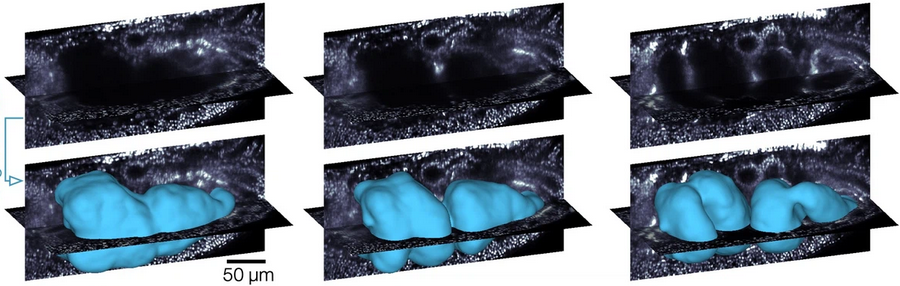

We have a mesh for every timepoint. Let's read it in.

In [7]:
metadata_dict = {'resolution_in_microns': (0.786, 0.786, 0.786)}

In [8]:
meshes_dict = {i: tcio.read_other_formats_without_uv(f"midgut_example/meshes/mesh_{str(i).zfill(2)}.obj")
               for i in tqdm(range(1, 21))}

# the function "tcio.read_other_formats_without_uv" can be used to read meshes of various file formats
# (if they don't contain UV info)

  0%|          | 0/20 [00:00<?, ?it/s]

We also have UV maps for the first and last timepoint in our time series.

In [27]:
mesh_initial_UV = tcio.ObjMesh.read_obj("midgut_example/initial_uv.obj") # time point 1
mesh_final_UV = tcio.ObjMesh.read_obj("midgut_example/final_uv.obj") # time point 20

### Aside - fixing UV maps

Especially for more complicated shapes, method like the cylindrical or spherical projection can give you UV maps with flipped triangles, i.e. the map from the mesh to the plane has self-intersections. This is not ideal for cartographic interpolation (although it will not cause cartographic interpolation to fail, just gives you a warning).

We can often fix this issue by smoothing out vertices in UV space while keeping the boundaries of the UV "islands" fixed. Let's take a look.

In [17]:
# the mesh has some flipped triangles
igl.flipped_triangles(mesh_final_UV.texture_vertices, mesh_final_UV.texture_tris)

array([  210,   245,   246,   261,   330, 11394, 11395, 11396, 11397,
       11398, 11399, 11400, 11570, 11571, 11572, 11573, 11574, 11575,
       11576, 11577, 11578, 11579, 11580, 11581, 11586, 11684, 11725,
       11726, 11730, 11731, 11732, 11733, 11734, 11736, 11737, 11738,
       11832, 11833, 11834, 11835, 11836, 11837, 11838, 11852, 11853,
       11855, 11856, 11857, 11858, 11859, 11860, 11865, 11866, 11867,
       11868, 11956, 11959, 11963, 11964, 11967, 11973, 11974, 11975,
       11976, 11977, 12093, 12094, 12098, 12102, 12105, 12106, 12108,
       12109, 12110, 12111, 12112, 12113, 12114, 12115, 12120, 12121,
       12129, 12130, 12131, 12132, 12133, 12134, 12135, 12136, 12137,
       12138, 12139, 12140, 12141, 12142, 12143, 12144, 12145, 12149,
       12150, 12151, 12152, 12153, 12154, 12160, 12175, 12183, 12199,
       12241, 12242, 12243, 12244, 12245, 12246, 12247, 12355, 12356,
       12360, 12361, 12362, 12363, 12366, 12367, 12371, 12372, 12373,
       12374, 12376,

In [28]:
mesh_final_UV = tcwrap.smooth_laplacian_texture(mesh_final_UV, lamb=0.5, n_iter=2500, boundary="fixed")

In [30]:
# and now they are mostly fixed
igl.flipped_triangles(mesh_final_UV.texture_vertices, mesh_final_UV.texture_tris)

array(261)

(0.03257265, 0.92952035, -0.0181902, 0.9884022)

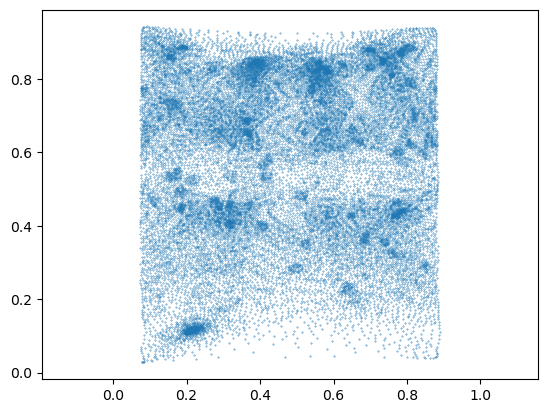

In [31]:
# the shape of the UV islands did not change.
plt.scatter(*mesh_final_UV.texture_vertices.T, s=0.1)
plt.axis("equal")

## Load image data

The image data shows fluorescently marked nuclei. The large "hole" in the center of the embryo is the developing midgut.

In [32]:
image = tcio.adjust_axis_order(tcio.imread("midgut_example/downsampled_3x/Time_000001_c1_stab-3x.tif"))
print("image shape:", image.shape)

image shape: (1, 247, 413, 200)


In [33]:
slice_image, slice_vertices = tcinterp.get_cross_section_vertices_normals(0, 150, image,
                            mesh_initial_UV, metadata_dict["resolution_in_microns"], width=2, get_normals=False)

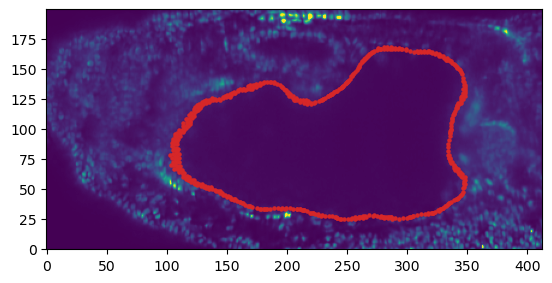

In [34]:
plt.scatter(*slice_vertices.T, s=5, c="tab:red")
plt.imshow(slice_image[0], vmax=10000, origin="lower")

## Mesh registration

Let's first see how we can register two meshes using rigid body transformations.

In [35]:
mesh_source = deepcopy(meshes_dict[1]) # the "source" mesh is the one we want to tranform to match the target
mesh_target = deepcopy(meshes_dict[1]) # for the target mesh, we take a copy that we will rotate+scale+translate

random_rotation = stats.special_ortho_group.rvs(3)
mesh_target.vertices = 1.1 * mesh_target.vertices @ random_rotation + np.array([100, 0, 0])

In [36]:
# registration proceeds in two steps: first, a coarse step gets an initial guess for the transformation

trafo_initial, _ = tcreg.align_by_centroid_and_intertia(mesh_source.vertices, mesh_target.vertices,
                                                        scale=True)
# and then the transformation is improved by the ICP algorithm (en.wikipedia.org/wiki/Iterative_closest_point)

trafo_icp, _, _ = tcreg.icp(mesh_source.vertices, mesh_target.vertices, initial=trafo_initial,
                            threshold=1e-4, max_iterations=200, include_scaling=True, n_samples=10000)

In [37]:
# a transformation is represented by a 4*4 matrix (en.wikipedia.org/wiki/Affine_transformation#Augmented_matrix)
trafo_icp

array([[ -0.33481982,   0.5663229 ,   0.88130666, 100.12547619],
       [ -0.92947084,   0.26932741,  -0.52252474,   0.03525151],
       [ -0.48907168,  -0.90324193,   0.39543405,   0.21661484],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [38]:
# let's apply the transformation and check we get the target mesh

mesh_registered = mesh_source.apply_affine_to_mesh(trafo_icp)

# indeed, the distance between the vertices is very small.
np.linalg.norm(mesh_registered.vertices-mesh_target.vertices, axis=-1).mean()

0.12687255365401112

## Shrink-wrapping pipeline

Now let's try to serially shrink-wrap our initial mesh onto the subsequent timepoints, as described above. We use the function `tcwrap.shrinkwrap_igl` for this. It is useful to slightly smooth both the keyframe and the target of the shrinkwrap a little before shrinkwrapping, which you can control using the arguments `n_iter_smooth_target, n_iter_smooth_wrapped`. 

You can also try out shrinkwrapping in blender, using the shrinkwrap modifier as explained in tutorial 7. 

After wrapping, we use _on surface smoothing_ to remove creases potentially created by the shrink-wrapping.

You may need to experiment with the parameters a little.

In [39]:
# we initialize the list of shrink-wrapped meshes with our keyframe
meshes_wrapped = {1: mesh_initial_UV}

In [40]:
for i in tqdm(range(2, 21)):
    # we use the most recent deformed keyframe as input in the shrink-wrapping algorithm
    mesh_source = meshes_wrapped[i-1]
    mesh_target = meshes_dict[i]
    # register using ICP
    trafo_initial, _ = tcreg.align_by_centroid_and_intertia(mesh_source.vertices, mesh_target.vertices,
                                                            scale=True, choose_minimal_rotation=True)
    trafo_icp, _, _ = tcreg.icp(mesh_source.vertices, mesh_target.vertices, initial=trafo_initial,
                                max_iterations=100, n_samples=5000)
    mesh_registered = mesh_source.apply_affine_to_mesh(trafo_icp)
    # shrink-wrap
    mesh_wrapped = tcwrap.shrinkwrap_igl(mesh_registered, mesh_target,
                                         n_iter_smooth_target=1, n_iter_smooth_wrapped=0)
    # smooth out deformation on-surface - important!
    mesh_wrapped = tcwrap.smooth_laplacian_on_surface(mesh_wrapped, n_iter=5, lamb=0.5, n_iter_laplace=10)

    # append to list
    mesh_wrapped.write_obj(f"midgut_example/meshes_wrapped/mesh_{str(i).zfill(2)}_wrapped.obj")
    meshes_wrapped[i] = mesh_wrapped

  0%|          | 0/19 [00:00<?, ?it/s]

/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:206: RuntimeWarning: Warning: 2 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)
/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:206: RuntimeWarning: Warning: 5 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)


In [41]:
# the wrapped meshes contain the same UV map information as the original mesh

np.allclose(meshes_wrapped[20].texture_vertices, mesh_initial_UV.texture_vertices)

True

## Inspect in blender

Let's inspect the results in blender (`midgut_example/wrapping.blend`).

For the first, say 10 time points, this approach looks decent. After that, we encounter a problem: the surface if the gut deforms very strongly (by forming constrictions). If we do not use on-surface smoothing, we get poor results:

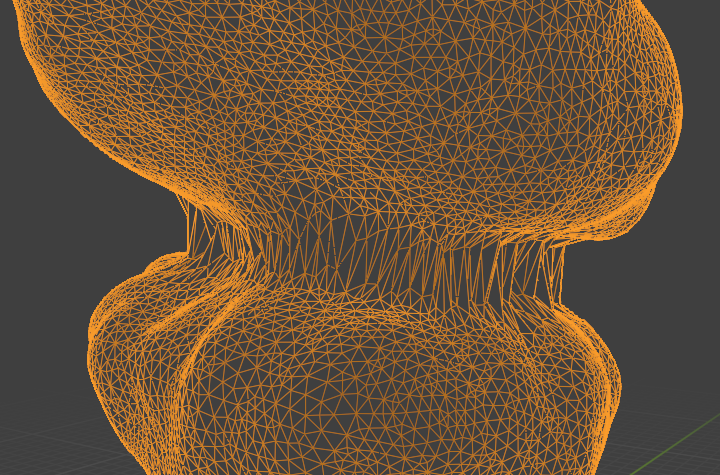

On-surface smoothing improves this a lot:

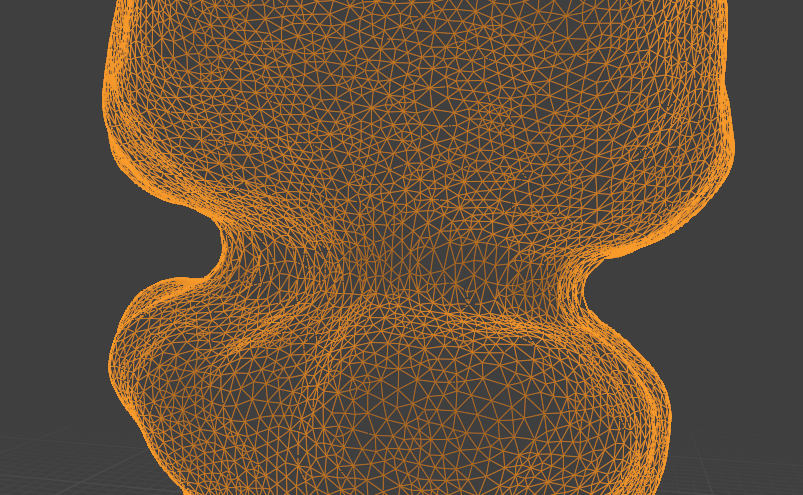

### Operate in reverse time

However, the shrink-wrapped mesh fails to capture some sharp details of the target meshes (close to the constrictions, for example).

As described above, it is generally best to use your most complicated shape as keyframe (here, the last timepoint), and deform it towards the simpler shapes. Hence, let us define a UV map for timepoint 20 and shrink-wrap reverse in time.

In [42]:
t_final = 20
meshes_wrapped_reverse = {20: mesh_final_UV}

In [43]:
for i in tqdm(reversed(range(1, t_final))):
    print(i)
    mesh_source = meshes_wrapped_reverse[i+1]
    mesh_target = meshes_dict[i]
    # register using ICP
    trafo_initial, _ = tcreg.align_by_centroid_and_intertia(mesh_source.vertices, mesh_target.vertices,
                                                            shear=True, choose_minimal_rotation=True)
    trafo_icp, _, _ = tcreg.icp(mesh_source.vertices, mesh_target.vertices, initial=trafo_initial,
                                max_iterations=100, include_scaling=True, n_samples=5000)
    mesh_registered = mesh_source.apply_affine_to_mesh(trafo_icp)
    # shrink-wrap
    mesh_wrapped = tcwrap.shrinkwrap_igl(mesh_registered, mesh_target,
                                         n_iter_smooth_target=1, n_iter_smooth_wrapped=1)
    # smooth out deformation on-surface
    mesh_wrapped = tcwrap.smooth_laplacian_on_surface(mesh_wrapped, n_iter=5, lamb=0.5, n_iter_laplace=10)
    # append to list
    mesh_wrapped.write_obj(f"midgut_example/meshes_wrapped_reverse/mesh_{str(i).zfill(2)}_wrapped_reverse.obj")
    meshes_wrapped_reverse[i] = mesh_wrapped

0it [00:00, ?it/s]

19


/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:206: RuntimeWarning: Warning: 3 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)


18
17
16
15
14
13
12
11
10


/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:206: RuntimeWarning: Warning: 1 normal(s) flipped during shrink-wrapping
  warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)


9
8
7
6
5
4
3
2
1


### Inspect in blender

The results look decent enough.


Let's visualize the UV maps on the wrapped meshes by adding an image texture the shading workspace. We can use a _color grid_ to visualize the correspondence between the meshes:

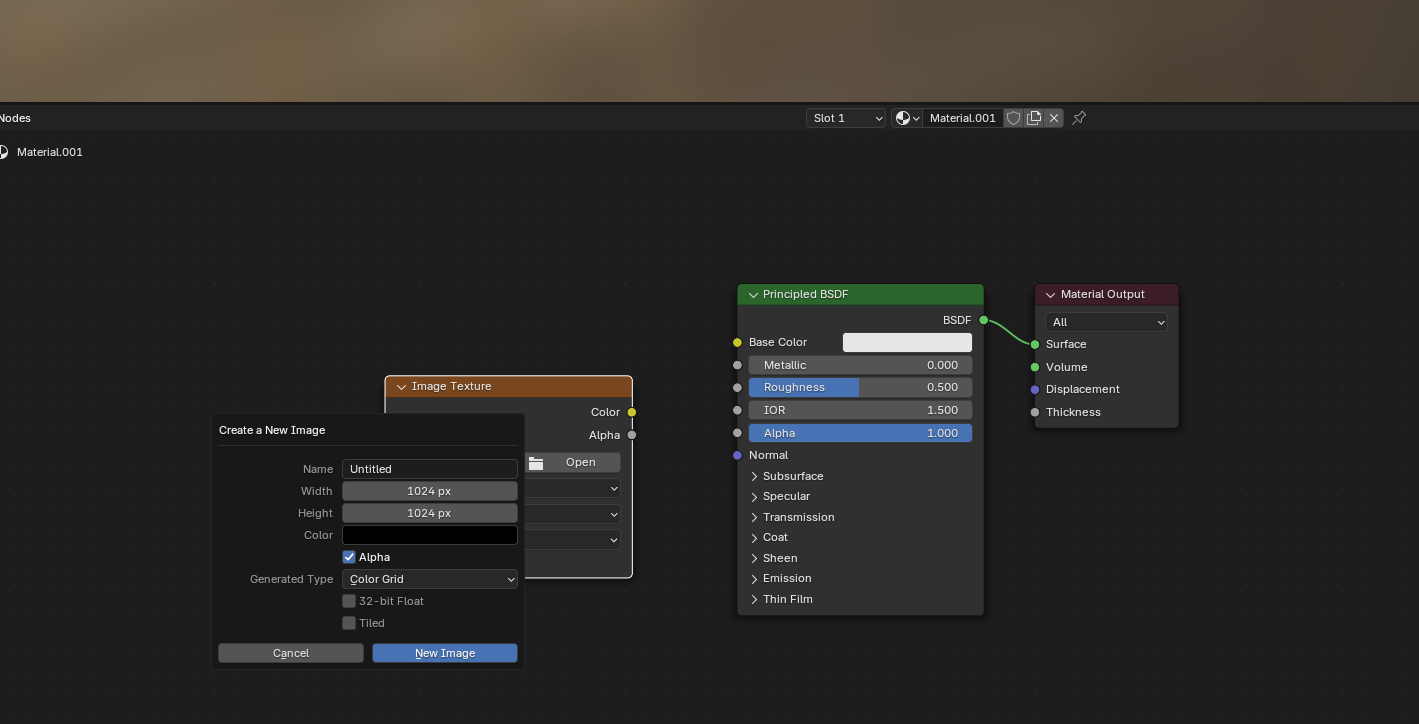

Let's show the keyframe mesh `final_uv`, and the shrink-wrapped one side by side:

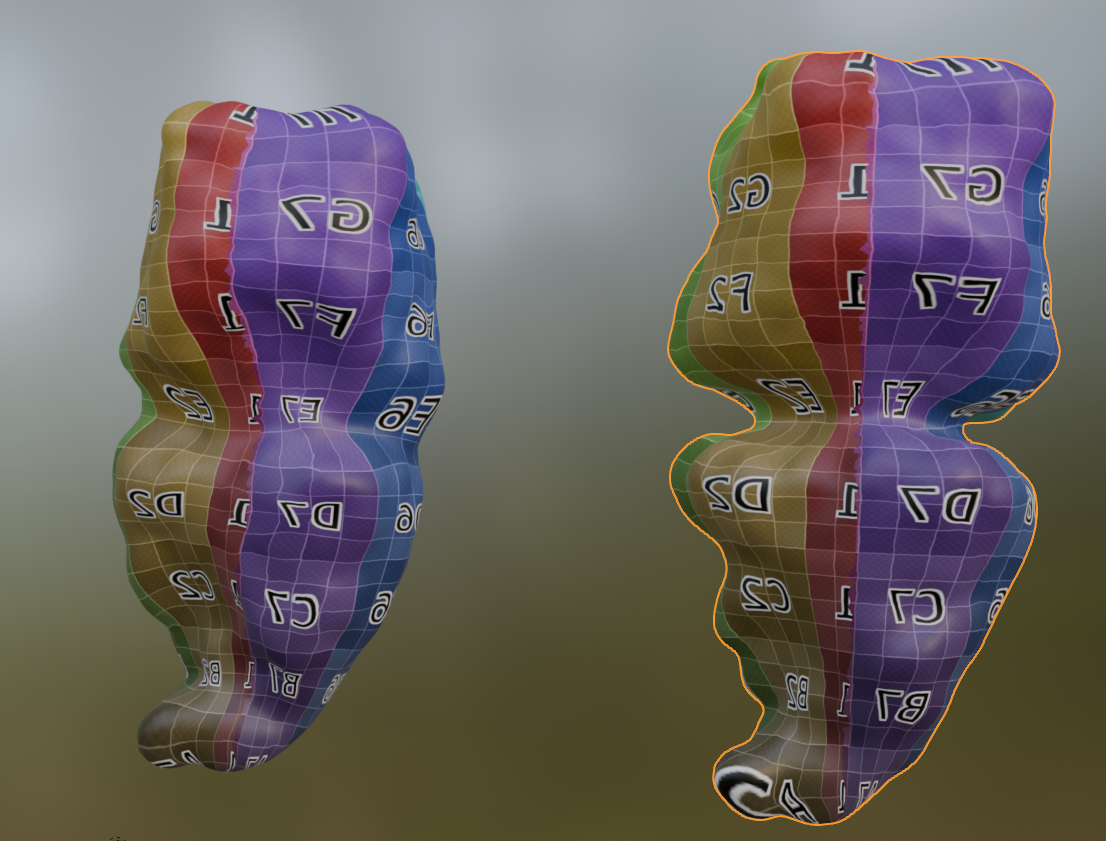

Looks good (except for the fact that I somehow flippe the mesh orientations ...)


### Remeshing 

As noted above, most remeshing algorithms destroy UV information. However, there are two exceptions:
1. Subdivision - this type of algorithm refines meshes by adding new vertices and faces to a mesh according to a pre-determined rule (for example, place a new vertex at each triangle midpoint). Since there is a well-defined map between the topology before and after subdivision, the UV info is preserved. Note: subdivision will greatly increase the size of your mesh, and it may become too large computationally. A variant is adaptive subdivision (subdividing certain parts of the mesh only, e.g. deformed triangles). 
2. Edge flips - this changes the configuration of faces whithout moving vertices. Only implemented for triangle meshes.

These algorithms may become very useful to improve the mesh quality of your keyframed mesh as you deform it, and are implemented in the `remesh` module. Adaptive subdivision requires pymeshlab, see `remesh_pymeshlab` module.

In [15]:
# let's test this
mesh_test = deepcopy(mesh_final_UV)

In [16]:
mesh_subdiv = tcremesh.subdivide_igl(mesh_test, reglue=True) 

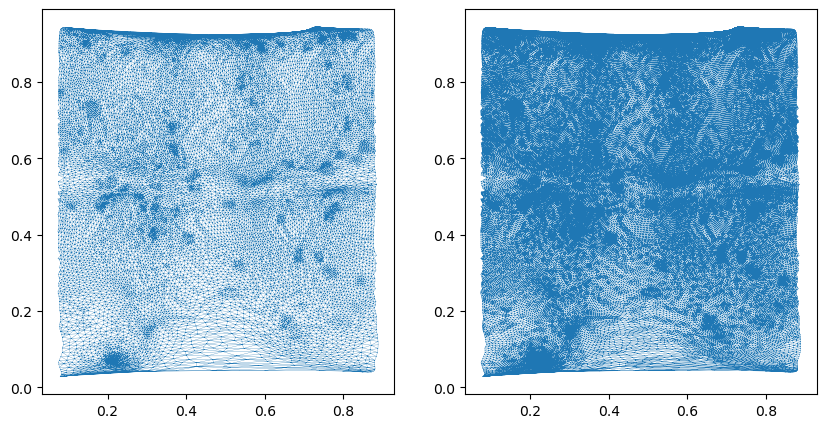

In [21]:
# as you can see, the mesh resolution is greatly increased

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

ax1.triplot(*mesh_test.texture_vertices.T, mesh_test.texture_tris, lw=0.2)
ax2.triplot(*mesh_subdiv.texture_vertices.T, mesh_subdiv.texture_tris, lw=0.2)

In [23]:
# the second algorithm involves changing the faces of the mesh by "edge flips" without moving vertices
# with the goal to make the mesh triangles more regularly sized (so-called Delaunay triangulation)

mesh_flipped = tcremesh.make_delaunay(mesh_test)

### Large deformations

For very large deformations, shrink-wrapping does not work. As noted above, we provide an implementation Moebius registration, which first maps the two meshes of interest to the sphere, and then aligns them via 3d rotations. This algorithm is more time-consuming, but can handle large deformations. It is implemented in the `conformal` module as `conformal.wrap_coords_via_sphere`. For meshes with disk topology, a similar algorithm is provided, `conformal.wrap_coords_via_disk`.

For the indidual components of the algorithms, namely (a) the map to sphere/disk and (b) rotational alignment, see the documentation in notebook 03d. Note that you can also use your own methods to map surfaces to the sphere or disk, or use an external tool like [boundary-first-flattening](https://github.com/GeometryCollective/boundary-first-flattening).

General-purpose code for shrink-wrapping via a shared parametrization is also provided.

In [56]:
# let's try to shrink-wrap the final onto the initial mesh

#mesh_source = deepcopy(mesh_final_UV)
#mesh_target = deepcopy(meshes_dict[1])

mesh_source = deepcopy(mesh_initial_UV)
mesh_target = deepcopy(meshes_dict[20])

In [57]:
# compute the new coordinates for the keyframe mesh mesh_source.
# for the meaning of the parameters, type help(wrap_coords_via_sphere)

new_coords, overlap = tcconf.wrap_coords_via_sphere(mesh_source, mesh_target, method="harmonic")

In [58]:
# 'overlap' measures the overlap between source and target geometry and gives an idea of how different the
# two shapes are and how well the wrapping worked. 1 is perfect alignment

overlap

0.918174332653755

In [59]:
# let's save the mesh and display it in blender

mesh_wrapped = deepcopy(mesh_source)
mesh_wrapped.vertices = new_coords
mesh_wrapped.set_normals()
mesh_wrapped.write_obj("midgut_example/wrapped_moebius_20.obj")

# we could combine this with some on-surface smoothing if desired

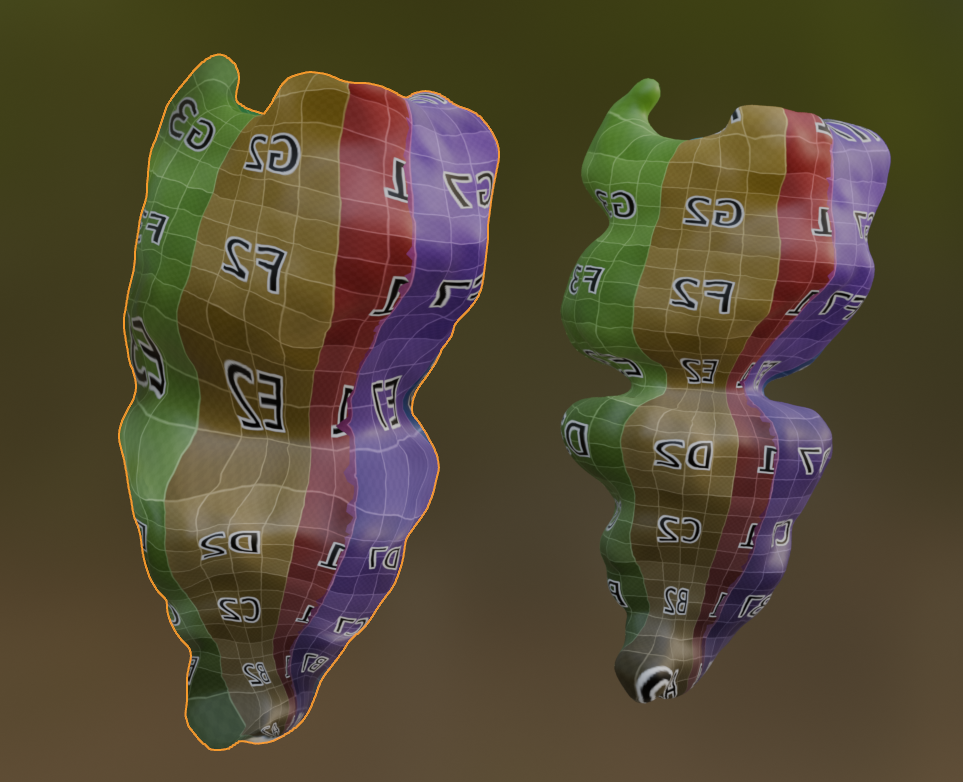

We can also overlay it with the mesh from timepoint 1 to see that they match perfectly.

### Cartographic projections

Finally, let's use the results to make some cartographic projections

In [60]:
normal_offsets = [0,] #np.linspace(-5, 5, 11) # in microns
metadata_dict["normal_offsets"] = normal_offsets # add the info to the metadata
uv_grid_steps = 1024

In [61]:
projected_data_tpt_20, projected_coordinates_tpt_20, projected_normals_tpt_20 = tcinterp.create_cartographic_projections(
    image="midgut_example/downsampled_3x/Time_000020_c1_stab-3x.tif",
    mesh="midgut_example/wrapped_moebius_20.obj",
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=uv_grid_steps)

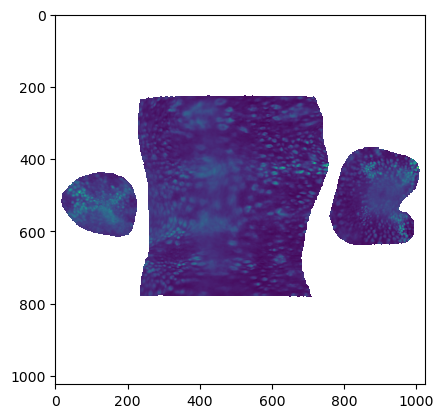

In [62]:
plt.imshow(projected_data_tpt_20[0][0])

In [64]:
projected_data_tpt_1, projected_coordinates_tpt_1, projected_normals_tpt_1 = tcinterp.create_cartographic_projections(
    image="midgut_example/downsampled_3x/Time_000001_c1_stab-3x.tif",
    mesh=mesh_initial_UV,
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=uv_grid_steps)

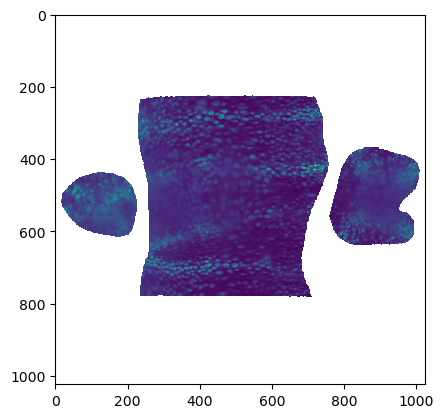

In [65]:
plt.imshow(projected_data_tpt_1[0][0])